In [1]:
import geopandas as gpd
import warnings
import folium
from shapely.geometry import mapping

# Игнорирование предупреждений
warnings.simplefilter(action='ignore', category=FutureWarning)

# Чтение shapefile для станций
shapefile_stations_path = "/kaggle/input/rzhd-hack/stationsv2.shp"
shapefile_stations = gpd.read_file(shapefile_stations_path)

# Выделение координат в отдельные столбцы для станций
shapefile_stations['longitude'] = shapefile_stations.geometry.x
shapefile_stations['latitude'] = shapefile_stations.geometry.y



In [2]:
# Инициализация карты Folium, центрируем карту на среднем значении координат станций
m = folium.Map(location=[shapefile_stations['latitude'].mean(), shapefile_stations['longitude'].mean()], zoom_start=5, tiles='OpenStreetMap')

# Добавление точек станций на карту
for idx, row in shapefile_stations.iterrows():
    folium.Marker(
        location=[row['latitude'], row['longitude']],
        popup=row['name'],
    ).add_to(m)

# Сохранение карты в HTML
m.save("stations_map.html")

# Вывод карты (если используется Jupyter Notebook)
m

In [3]:
# Load the shapefile
shapefile2 = gpd.read_file("/kaggle/input/rzhd-hack/all_routes_v2.shp")


In [4]:
shapefile2['maxspeed'].unique()

array([None, '100', '40', "['80', '100']", '80', '70', '120',
       "['120', '100']", "['90', '100']", "['140', '120', '100']",
       "['140', '120']", "['70', '100']", "['40', '100']", '90',
       "['90', '60']", "['80', '90']", "['40', '80', '100']",
       "['80', '120']", '140', "['90', '40', '60']",
       "['140', '120', '115', '100']", "['120', '90']",
       "['120', '80', '100']", "['120', '100', '140', '95', '110']",
       "['120', '100', '130', '95', '110']",
       "['120', '100', '80', '140', '90']", "['140', '100']",
       "['95', '100']", '110', "['80', '70']", "['140', '80']",
       "['140', '80', '120']", "['110', '120', '130', '100']", '25',
       "['120', '60']", '60', "['120', '70']", "['85', '110']",
       "['95', '90', '120', '100']", "['120', '80', '85', '95', '90']",
       "['80', '120', '100']", "['140', '120', '80']",
       "['120', '80', '160']", "['120', '110']", "['140', '115', '100']",
       "['90', '115']", "['130', '100']", "['120', '130', '10

In [5]:
shapefile2['maxspeed'].fillna(80, inplace=True)

for i, a in enumerate(shapefile2['maxspeed']):
    if type(a) is str:
        if a[0] == '[':
            shapefile2['maxspeed'].iloc[i] = a.strip('][').split(", ")
            shapefile2['maxspeed'].iloc[i] = [int(j.strip("''")) for j in shapefile2['maxspeed'].iloc[i]]
            shapefile2['maxspeed'].iloc[i] = sum([int(j) for j in shapefile2['maxspeed'].iloc[i]]) / len(shapefile2['maxspeed'].iloc[i])
        else:
            shapefile2['maxspeed'].iloc[i] = int(shapefile2['maxspeed'].iloc[i])
    elif type(a) is list:
        shapefile2['maxspeed'].iloc[i] = sum([int(j) for j in a]) / len(a)

In [6]:
shapefile2['maxspeed'].value_counts()

maxspeed
80            20519
100            1723
120            1583
40             1373
110.0           335
140             270
60              270
90.0            262
70              179
130.0           170
95.0             57
85.0             39
115.0            37
113.333333       27
105.0            22
160              21
75.0             13
50               11
170.0            10
116.666667       10
97.5              9
180               7
117.5             7
103.75            6
93.333333         6
106.875           6
121.666667        6
133.333333        6
123.333333        6
122.5             6
63.333333         6
102.5             5
118.333333        5
200               5
105.833333        4
103.333333        4
25                4
106.0             4
150.0             3
112.5             2
73.333333         2
125.0             2
94.0              2
111.0             2
83.333333         2
101.25            2
152.5             2
113.0             1
118.75            1
111.666667 

In [7]:
# Assuming the columns for origin, destination, and distance are named 'origin', 'destination', and 'distance'
# Separating geometry from other columns
geometry = shapefile2.geometry
non_geometry = shapefile2.drop(columns='geometry')

# Aggregating non-geometry columns by summing the distances
aggregated_non_geometry = non_geometry.groupby(['origin', 'destinatio']).agg({'length': 'sum', 'maxspeed': 'mean'}).reset_index()

# Aggregating geometry columns by grouping and applying unary_union
aggregated_geometry = shapefile2.groupby(['origin', 'destinatio'])['geometry'].apply(lambda x: x.unary_union).reset_index()

# Merging the aggregated non-geometry data with the aggregated geometry
aggregated_data = aggregated_non_geometry.merge(aggregated_geometry, on=['origin', 'destinatio'])

# Converting to GeoDataFrame
aggregated_data = gpd.GeoDataFrame(aggregated_data, geometry='geometry')

# Print the result
print(aggregated_data)

                    origin                     destinatio         length  \
0       Александро-Невская                         Рыбное  366205.310940   
1   Бекасово-Сортировочное                        Вековка  582400.951675   
2   Бекасово-Сортировочное          Люблино-Сортировочное  152592.604138   
3   Бекасово-Сортировочное                  Малоярославец   90812.379613   
4   Бекасово-Сортировочное  Москва-Сортировочная-Киевская  102367.038251   
..                     ...                            ...            ...   
75                   Унеча                       Стародуб   72839.885639   
76                 Фрязево                        Ногинск   31451.733248   
77                 Щёлково               Лосиноостровская   63559.332180   
78       Ярославль-Главный               Лосиноостровская  379289.772135   
79       Ярославль-Главный                  Орехово-Зуево  446382.194123   

     maxspeed                                           geometry  
0        80.0  MULTI

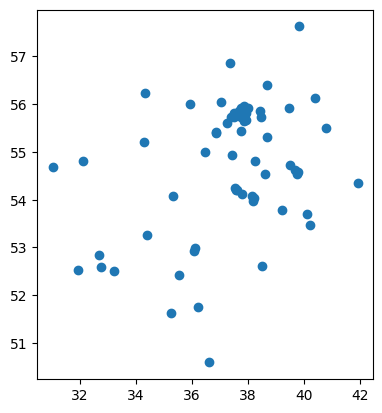

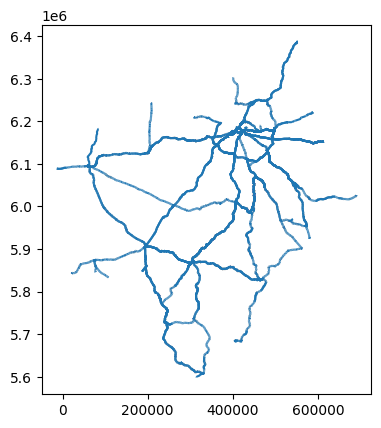

In [8]:
import matplotlib.pyplot as plt

shape2 = aggregated_data
shapefile_stations.plot()
plt.show()

shape2.plot()
plt.show()


In [9]:
import geopandas as gpd

# Assuming your GeoDataFrame 'shapefile2' has a proper CRS set
# Calculate the length of each geometry in meters
aggregated_data['length_km'] = aggregated_data['geometry'].length / 1000

# Print the result
print(aggregated_data[['origin','destinatio','geometry', 'length_km', "maxspeed"]])

                    origin                     destinatio  \
0       Александро-Невская                         Рыбное   
1   Бекасово-Сортировочное                        Вековка   
2   Бекасово-Сортировочное          Люблино-Сортировочное   
3   Бекасово-Сортировочное                  Малоярославец   
4   Бекасово-Сортировочное  Москва-Сортировочная-Киевская   
..                     ...                            ...   
75                   Унеча                       Стародуб   
76                 Фрязево                        Ногинск   
77                 Щёлково               Лосиноостровская   
78       Ярославль-Главный               Лосиноостровская   
79       Ярославль-Главный                  Орехово-Зуево   

                                             geometry   length_km   maxspeed  
0   MULTILINESTRING ((580388.745 5926227.814, 5804...  207.117385       80.0  
1   MULTILINESTRING ((589802.650 6148604.962, 5897...  409.087282  81.370158  
2   MULTILINESTRING ((420474.2

In [10]:
import pandas as pd

In [11]:
train_df = pd.read_csv("/kaggle/input/rzhd-hack/dataset_external.csv")
train_df

,index,value,route_start,route_end
0,1198,4.150000,Кусково,Яничкино
1,2983,14.300000,Вековка,Курск
2,3418,7.116667,Люблино-Сортировочное,Рязань-2
3,1955,20.333333,Красное,Погар
4,1697,13.900000,Белгород,Елец
...,...,...,...,...
1514,2424,10.683333,Люберцы II,Волоколамск
1515,1364,9.166667,Волоколамск,Вековка
1516,1419,10.866667,Перово,Елец
1517,1723,9.483333,Волоколамск,Узуново


In [12]:
import geopandas as gpd
import networkx as nx


In [13]:
all_routes = aggregated_data


# Create an empty graph
G = nx.Graph()

# Add nodes (stations) to the graph
stations = set(all_routes['origin']).union(set(all_routes['destinatio']))
G.add_nodes_from(stations)

# Add edges (routes) to the graph with distance as weight
for index, row in all_routes.iterrows():
    G.add_edge(row['origin'], row['destinatio'], weight=row['length_km'])
    # Assuming undirected graph, add the reverse edge
    G.add_edge(row['destinatio'], row['origin'], weight=row['length_km'])
    
# Create an empty graph
F = nx.Graph()

# Add nodes (stations) to the graph
stations = set(all_routes['origin']).union(set(all_routes['destinatio']))
F.add_nodes_from(stations)

# Add edges (routes) to the graph with distance as weight
for index, row in all_routes.iterrows():
    F.add_edge(row['origin'], row['destinatio'], weight=row['length_km']/row['maxspeed'])
    # Assuming undirected graph, add the reverse edge
    F.add_edge(row['destinatio'], row['origin'], weight=row['length_km']/row['maxspeed'])


In [14]:
missing_routes=pd.DataFrame([['Аэропорт','Москва-Сортировочная-Киевская',30],
                             ['Аэропорт','Кунцево II',26.7],
                             ['Аэропорт','Москва-Товарная-Смоленская',38],
                             ['Бекасово-Центральное','Бекасово-Сортировочное',1.9],
                             ['Бекасово-Центральное','Малоярославец',60],
                             ['Бекасово-Центральное','Аэропорт',40],
                             ['Брянск-Орловский','Сухиничи-Главные',140],
                             ['Брянск-Орловский','Лужки-Орловские',133],
                             ['Брянск-Орловский','Смоленск-Сортировочный',400],
                             ['Домодедово','Ожерелье',90],
                             ['Домодедово','Узуново',130],
                             ['Домодедово','Фрязево',100],
                             ['Люберцы II','Перово',25.4],
                             ['Люберцы II','Яничкино',10],
                             ['Люберцы II','Поварово-3',93],
                             ['Павелец-Тульский','Узуново',120],
                             ['Павелец-Тульский','Узловая-I',90],
                             ['Павелец-Тульский','Ряжск I',75],
                             ['Перово','Кусково',2],
                             ['Перово','Ряжск I',320],
                             ['Перово','Балашиха',15],
                             ['Стенькино-II','Рыбное',39],
                             ['Стенькино-II','Ряжск I',110],
                             ['Стенькино-II','Сасово',200],
                             ['Тула-Вяземская','Присады',20],
                             ['Тула-Вяземская','Серпухов',100],
                             ['Тула-Вяземская','Елец',220],
                             ['Присады','Узловая-I',40],
                             ['Присады','Павелец-Тульский',130],
                             ['Присады','Серпухов',120],
                             ['Александров-1','Зелёный бор',100],
                             ['Савёлово','Подмосковная',170]
                            ])
missing_routes
for index, row in missing_routes.iterrows():
    G.add_edge(row[0], row[1], weight=row[2])
    # Assuming undirected graph, add the reverse edge
    G.add_edge(row[1], row[0], weight=row[2])
    
for index, row in missing_routes.iterrows():
    F.add_edge(row[0], row[1], weight=row[2]/80)
    # Assuming undirected graph, add the reverse edge
    F.add_edge(row[1], row[0], weight=row[2]/80)

In [15]:
import plotly.graph_objects as go
def draw_graph(graph, title):
    pos = nx.spring_layout(graph)  # Расположение узлов с использованием spring layout

    # Получаем координаты узлов
    x_nodes = [pos[node][0] for node in graph.nodes()]
    y_nodes = [pos[node][1] for node in graph.nodes()]

    # Создаем рёбра
    edge_x = []
    edge_y = []
    for edge in graph.edges():
        x0, y0 = pos[edge[0]]
        x1, y1 = pos[edge[1]]
        edge_x.extend([x0, x1, None])
        edge_y.extend([y0, y1, None])

    # Создаем фигуру для узлов и рёбер
    edge_trace = go.Scatter(
        x=edge_x, y=edge_y,
        line=dict(width=1, color='gray'),
        hoverinfo='none',
        mode='lines')

    node_trace = go.Scatter(
        x=x_nodes, y=y_nodes,
        mode='markers+text',
        hoverinfo='text',
        text=[f'{node}<br>degree: {degree}' for node, degree in graph.degree()],
        marker=dict(
            showscale=True,
            colorscale='YlGnBu',
            size=10,
            color=list(nx.degree_centrality(graph).values()),
            colorbar=dict(
                thickness=15,
                title='Node Degree',
                xanchor='left',
                titleside='right'
            ),
        ),
        textposition='top center'
    )

    # Создаем структуру графа
    fig = go.Figure(data=[edge_trace, node_trace],
                    layout=go.Layout(
                        title=title,
                        titlefont_size=16,
                        showlegend=False,
                        hovermode='closest',
                        margin=dict(b=20, l=5, r=5, t=40),
                        annotations=[dict(
                            text="Railway Graph Visualization",
                            showarrow=False,
                            xref="paper", yref="paper"
                        )],
                        xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                        yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
                    )
    fig.show()

In [16]:
# Визуализация графов
draw_graph(G, 'Graph G - Distances')

In [17]:
draw_graph(F, 'Graph F - Travel Time')

In [18]:
# Function to find shortest path between start and end stations
def find_shortest_path(start_station, end_station):
    try:
        if not (start_station in G and end_station in G):
            return 0, 0, 0,0,0
        else:
            shortest_path = nx.shortest_path(G, start_station, end_station, weight='weight')
            shortest_distance = nx.shortest_path_length(G, start_station, end_station, weight='weight')
            num_stations = len(shortest_path) - 1
            # Расчет расстояний между соседними станциями
            distances_between_stations = []
            for i in range(len(shortest_path) - 1):
                distances_between_stations.append(G[shortest_path[i]][shortest_path[i + 1]]['weight'])
            return shortest_path, shortest_distance, num_stations, min(distances_between_stations), max(distances_between_stations)
    except nx.NetworkXNoPath:
        return None, float('inf'), float('inf'), float('inf'), float('inf'), 

# Функция для поиска самого быстрого пути
def find_fastest_path(start_station, end_station):
    try:
        if not (start_station in F and end_station in F):
            return 0, 0, 0, 0, 0
        else:
            fastest_path = nx.dijkstra_path(F, start_station, end_station, weight='weight')
            fastest_distance = nx.dijkstra_path_length(F, start_station, end_station, weight='weight')
            num_stations_fast = len(fastest_path) - 1
            # Расчет времени между соседними станциями
            times_between_stations = []
            for i in range(len(fastest_path) - 1):
                times_between_stations.append(F[fastest_path[i]][fastest_path[i + 1]]['weight'])
            return fastest_path, fastest_distance, num_stations_fast, min(times_between_stations), max(times_between_stations)
    except nx.NetworkXNoPath:
        return None, float('inf'), float('inf'), float('inf'), float('inf'), 

# Example: Iterate over train_df to find optimal paths
for index, row in train_df.iterrows():
    start_station = row['route_start']
    end_station = row['route_end']
    
    shortest_path, shortest_distance, num_stations, min_distances_between_stations,max_distances_between_stations = find_shortest_path(start_station, end_station)
    fastest_path, fastest_distance, num_stations_fast, min_times_between_stations,max_times_between_stations = find_fastest_path(start_station, end_station)
    if shortest_path:
        # Update train_df with optimal distance
        train_df.at[index, 'optimal_distance_km'] = shortest_distance
        train_df.at[index, 'num_stations'] = num_stations
        train_df.at[index, 'min_distances_between_stations'] = min_distances_between_stations
        train_df.at[index, 'max_distances_between_stations'] = max_distances_between_stations
    else:
        train_df.at[index, 'optimal_distance_km'] = 0  # or any default value for no path found
        train_df.at[index, 'num_stations'] = 0
        train_df.at[index, 'min_distances_between_stations'] = 0
        train_df.at[index, 'max_distances_between_stations'] = 0
    if fastest_path:
        # Update train_df with optimal distance
        train_df.at[index, 'optimal_distance_hours'] = fastest_distance
        train_df.at[index, 'num_stations_fast'] = num_stations_fast
        train_df.at[index, 'min_times_between_stations'] = min_times_between_stations
        train_df.at[index, 'max_times_between_stations'] = max_times_between_stations
    else:
        train_df.at[index, 'optimal_distance_hours'] = 0
        train_df.at[index, 'num_stations_fast'] = 0
        train_df.at[index, 'min_times_between_stations'] = 0
        train_df.at[index, 'max_times_between_stations'] = 0

# Print updated train_df
#print(train_df)



In [19]:
test_df = pd.read_csv("/kaggle/input/rzhd-hack/dataset_internal.csv")

In [20]:
# Example: Iterate over train_df to find optimal paths
for index, row in test_df.iterrows():
    start_station = row['route_start']
    end_station = row['route_end']
    
    shortest_path, shortest_distance, num_stations, min_distances_between_stations,max_distances_between_stations = find_shortest_path(start_station, end_station)
    fastest_path, fastest_distance, num_stations_fast, min_times_between_stations,max_times_between_stations = find_fastest_path(start_station, end_station)
    if shortest_path:
        # Update train_df with optimal distance
        test_df.at[index, 'optimal_distance_km'] = shortest_distance
        test_df.at[index, 'num_stations'] = num_stations
        test_df.at[index, 'min_distances_between_stations'] = min_distances_between_stations
        test_df.at[index, 'max_distances_between_stations'] = max_distances_between_stations
    else:
        test_df.at[index, 'optimal_distance_km'] = 0  # or any default value for no path found
        test_df.at[index, 'num_stations'] = 0
        test_df.at[index, 'min_distances_between_stations'] = 0
        test_df.at[index, 'max_distances_between_stations'] = 0
    if fastest_path:
        # Update train_df with optimal distance
        test_df.at[index, 'optimal_distance_hours'] = fastest_distance
        test_df.at[index, 'num_stations_fast'] = num_stations_fast
        test_df.at[index, 'min_times_between_stations'] = min_times_between_stations
        test_df.at[index, 'max_times_between_stations'] = max_times_between_stations
    else:
        test_df.at[index, 'optimal_distance_hours'] = 0
        test_df.at[index, 'num_stations_fast'] = 0
        test_df.at[index, 'min_times_between_stations'] = 0
        test_df.at[index, 'max_times_between_stations'] = 0

# Print updated train_df
print(test_df)


      index                 route_start               route_end  \
0      2623                      Вязьма                 Щёлково   
1      4413                    Аэропорт                   Лесок   
2       480                     Узуново           Малоярославец   
3      4409                    Серпухов                   Лесок   
4      9286                  Кунцево II                 Петушки   
...     ...                         ...                     ...   
1514   1676                        Елец                  Перово   
1515   8047                 Зелёный Бор                 Вековка   
1516     37  Москва-Товарная-Смоленская            Курбакинская   
1517   1179      Смоленск-Сортировочный                Владимир   
1518   8020                    Аэропорт  Бекасово-Сортировочное   

      optimal_distance_km  num_stations  min_distances_between_stations  \
0              757.835709           4.0                       37.363177   
1              441.045695           4.0      

In [21]:
import pandas as pd
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor, Pool, cv

# Assuming 'optimal_distance_km' is the target variable
X = train_df.drop(columns=["index",'value'])  # Features
y = train_df['value']  # Target variable

# Split data into training and testing sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.001, random_state=42)


In [22]:
# Define CatBoost parameters
'''catboost_params = {
    'iterations': 1000,
    'learning_rate': 0.1,
    'depth': 6,
    'loss_function': "RMSE",
    'random_seed': 42
}'''

import numpy as np
from catboost import CatBoostRegressor, Pool, cv

catboost_params = {
    'iterations': 1500,
    'learning_rate': 0.1,
    'depth': 7,
    "l2_leaf_reg": 3,
    "leaf_estimation_iterations": 10,
    'loss_function': "RMSE",
    'random_seed': 42
}

# Convert data to CatBoost Pool format
train_pool = Pool(data=X_train, label=y_train, cat_features = ['route_start',"route_end"])
val_pool = Pool(data=X_val, label=y_val, cat_features = ['route_start',"route_end"])

# Perform cross-validation
cv_results = cv(pool=train_pool,
                params=catboost_params,
                fold_count=5,  # Number of folds for cross-validation
                verbose=100,  # Print progress every 100 iterations
                plot=True)  # Plot training metrics



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]
0:	learn: 10.8332271	test: 10.8880810	best: 10.8880810 (0)	total: 61.9ms	remaining: 1m 32s
100:	learn: 1.1091160	test: 1.4779212	best: 1.4779212 (100)	total: 534ms	remaining: 7.4s
200:	learn: 0.7129448	test: 1.3609799	best: 1.3609799 (200)	total: 1.01s	remaining: 6.51s
300:	learn: 0.4937995	test: 1.2970145	best: 1.2968630 (296)	total: 1.47s	remaining: 5.86s
400:	learn: 0.3701468	test: 1.2733181	best: 1.2723272 (390)	total: 1.96s	remaining: 5.36s
500:	learn: 0.2859560	test: 1.2625764	best: 1.2625115 (499)	total: 2.43s	remaining: 4.85s
600:	learn: 0.2228763	test: 1.2578262	best: 1.2561684 (585)	total: 2.91s	remaining: 4.36s
700:	learn: 0.1797187	test: 1.2540651	best: 1.2538184 (693)	total: 3.37s	remaining: 3.84s
800:	learn: 0.1444111	test: 1.2501467	best: 1.2498300 (797)	total: 3.84s	remaining: 3.35s
900:	learn: 0.1193465	test: 1.2480517	best: 1.2480517 (900)	total: 4.36s	remaining: 2.9s
1000:	learn: 0.0985250	test: 1.2471960	best: 1.2465616 (989)	total: 4.82s	rema

In [23]:
# Get best iteration
best_iteration = 1463 # Use the number of iterations where the best metric was achieved
# Initialize CatBoostRegressor with best parameters
best_model = CatBoostRegressor(iterations=best_iteration,
                               learning_rate=0.1,
                               depth=7,
                               l2_leaf_reg= 3,
                               leaf_estimation_iterations = 10,
                               loss_function='RMSE',
                               random_seed=42)
train_pool = Pool(data=X, label=y, cat_features=['route_start',"route_end"])
best_model.fit(train_pool,verbose=100)  # Verbose to see progress every 100 iterations

0:	learn: 4.3093797	total: 5.71ms	remaining: 8.35s
100:	learn: 1.0991731	total: 471ms	remaining: 6.35s
200:	learn: 0.7326472	total: 929ms	remaining: 5.83s
300:	learn: 0.5350181	total: 1.38s	remaining: 5.34s
400:	learn: 0.4014024	total: 1.83s	remaining: 4.85s
500:	learn: 0.3132950	total: 2.29s	remaining: 4.39s
600:	learn: 0.2483991	total: 2.73s	remaining: 3.92s
700:	learn: 0.2030346	total: 3.21s	remaining: 3.5s
800:	learn: 0.1694819	total: 3.66s	remaining: 3.03s
900:	learn: 0.1404817	total: 4.12s	remaining: 2.57s
1000:	learn: 0.1200099	total: 4.58s	remaining: 2.11s
1100:	learn: 0.1020044	total: 5.03s	remaining: 1.65s
1200:	learn: 0.0879361	total: 5.59s	remaining: 1.22s
1300:	learn: 0.0772888	total: 6.09s	remaining: 759ms
1400:	learn: 0.0671404	total: 6.6s	remaining: 292ms
1462:	learn: 0.0612809	total: 6.91s	remaining: 0us


In [24]:
# Predict on test data
y_pred = best_model.predict(X_val)

from sklearn.metrics import mean_squared_error, mean_absolute_error

# Calculate RMSE and MAE
rmse = mean_squared_error(y_val, y_pred, squared=False)
mae = mean_absolute_error(y_val, y_pred)

print(f"RMSE: {rmse:.2f} hours")
print(f"MAE: {mae:.2f} hours")


RMSE: 0.66 hours
MAE: 0.52 hours


In [25]:
test_pool = Pool(data=test_df.drop(columns=["index"]), cat_features=['route_start',"route_end"])

# Assuming 'test_df' has similar structure as 'train_df' without 'optimal_distance_km'
test_pred = best_model.predict(test_pool)

# Print or use 'test_pred' as needed for your application
print(test_pred)

[12.06952148 11.86861956 10.82479248 ... 13.71411248  7.94090859
  5.30180329]


In [26]:
test_csv = pd.read_csv("/kaggle/input/rzhd-hack/dataset_internal.csv")
test_csv

,index,route_start,route_end
0,2623,Вязьма,Щёлково
1,4413,Аэропорт,Лесок
2,480,Узуново,Малоярославец
3,4409,Серпухов,Лесок
4,9286,Кунцево II,Петушки
...,...,...,...
1514,1676,Елец,Перово
1515,8047,Зелёный Бор,Вековка
1516,37,Москва-Товарная-Смоленская,Курбакинская
1517,1179,Смоленск-Сортировочный,Владимир


In [27]:
test_csv["value_predict"] = test_pred

In [28]:
test_csv.to_csv("cb_predict.csv")

In [29]:
feature_importances = best_model.feature_importances_
feature_names=X_val.columns
# Выводим важность признаков
for i, importance in enumerate(feature_importances):
    print(f"Feature {feature_names[i]}: {importance:.2f}")

Feature route_start: 10.93
Feature route_end: 11.61
Feature optimal_distance_km: 13.51
Feature num_stations: 13.66
Feature min_distances_between_stations: 5.91
Feature max_distances_between_stations: 7.10
Feature optimal_distance_hours: 9.09
Feature num_stations_fast: 9.87
Feature min_times_between_stations: 6.85
Feature max_times_between_stations: 11.47
